In [1]:
# ==============================================
# COMMON IMPORTS (Run this cell first)
# ==============================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error
import seaborn as sns
import os
import zipfile
import requests
import io

# Set random seeds for reproducibility (optional)
np.random.seed(42)
tf.random.set_seed(42)

print("TensorFlow Version:", tf.__version__)
print("Keras Version:", keras.__version__)

/Users/aditya/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


TensorFlow Version: 2.19.0
Keras Version: 3.9.2



--- Assignment 11: Q-Learning (FrozenLake) ---
Gym version: 0.26.2
FrozenLake-v1 environment created.
Selected render mode: ansi
Initializing Q-Table and hyperparameters...
Starting Q-Learning training for 15000 episodes...


/Users/aditya/Library/Python/3.9/lib/python/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 1500/15000... Epsilon: 0.231
Episode 3000/15000... Epsilon: 0.059
Episode 4500/15000... Epsilon: 0.021
Episode 6000/15000... Epsilon: 0.012
Episode 7500/15000... Epsilon: 0.011
Episode 9000/15000... Epsilon: 0.010
Episode 10500/15000... Epsilon: 0.010
Episode 12000/15000... Epsilon: 0.010
Episode 13500/15000... Epsilon: 0.010
Episode 15000/15000... Epsilon: 0.010
Training finished.

Final Q-Table:
[[0.026 0.026 0.026 0.025]
 [0.008 0.003 0.008 0.019]
 [0.008 0.009 0.011 0.011]
 [0.002 0.002 0.01  0.01 ]
 [0.058 0.006 0.011 0.008]
 [0.    0.    0.    0.   ]
 [0.001 0.    0.011 0.   ]
 [0.    0.    0.    0.   ]
 [0.09  0.04  0.003 0.065]
 [0.022 0.072 0.045 0.01 ]
 [0.014 0.005 0.006 0.004]
 [0.    0.    0.    0.   ]
 [0.    0.    0.    0.   ]
 [0.112 0.027 0.168 0.076]
 [0.126 0.177 0.198 0.84 ]
 [0.    0.    0.    0.   ]]


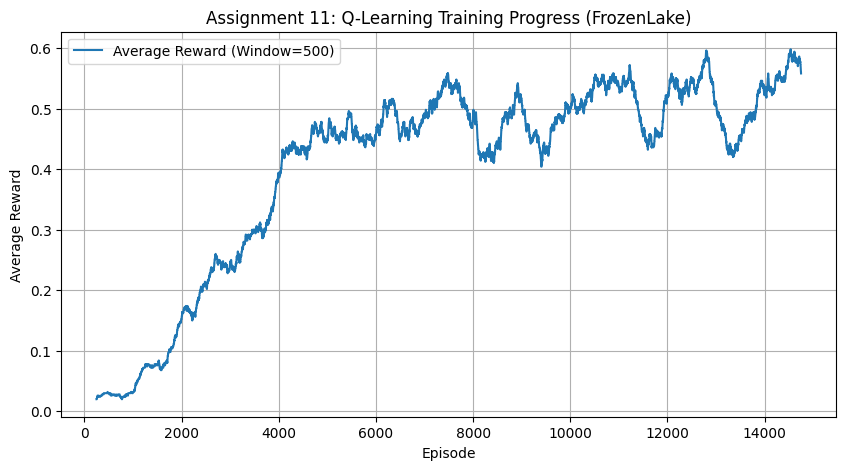


Testing the trained agent...

--- Test Episode 1 ---
None
None
None
None
None
Episode finished in 5 steps. Outcome: Failure (Fell in Hole).

--- Test Episode 2 ---
None
None
None
None
None
Episode finished in 5 steps. Outcome: Failure (Fell in Hole).

--- Test Episode 3 ---
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
Episode finished in 56 steps. Outcome: Failure (Fell in Hole).

--- Test Episode 4 ---
None
None
None
Episode finished in 3 steps. Outcome: Failure (Fell in Hole).

--- Test Episode 5 ---
None
None
None
None
None
None
None
None
Episode finished in 8 steps. Outcome: Failure (Fell in Hole).

--- Test Episode 6 ---
None
None
None
None
None
None
None
None
None
None
None
None
Episode finished in 12 steps. Outcome: Failure (Fell in Hole).

--- Te

/Users/aditya/Library/Python/3.9/lib/python/site-packages/gym/envs/toy_text/frozen_lake.py:271: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym("FrozenLake-v1", render_mode="rgb_array")
  logger.warn(


In [2]:
# ==============================================
# Assignment 11: Q-Learning (FrozenLake)
# CELL START
# ==============================================
print("\n--- Assignment 11: Q-Learning (FrozenLake) ---")

# --- Imports ---
import numpy as np
import matplotlib.pyplot as plt
import random # For exploration-exploitation
import time # Optional for rendering delay

# Try importing gym and handle potential errors
try:
    import gym
    print(f"Gym version: {gym.__version__}")
except ImportError:
    print("Error: OpenAI Gym not installed. Please install using 'pip install gym gymnasium'")
    gym = None # Mark gym as unavailable

# --- Reproducibility (for random exploration) ---
np.random.seed(42)
random.seed(42)


# --- Environment Setup ---
env = None
render_mode = None # 'ansi' or 'human'
if gym:
    try:
        # Try creating the environment
        env = gym.make('FrozenLake-v1', is_slippery=True) # is_slippery=True is default and more challenging
        print("FrozenLake-v1 environment created.")

        # Determine suitable render mode
        available_modes = env.metadata.get('render_modes', [])
        if 'ansi' in available_modes:
            render_mode = 'ansi'
        elif 'human' in available_modes:
            render_mode = 'human' # Fallback for local display
        else:
            print("Warning: Neither 'ansi' nor 'human' render mode available.")
        print(f"Selected render mode: {render_mode}")

    except gym.error.NameNotFound:
        print("Error: 'FrozenLake-v1' environment not found. It might need registration or gym version check.")
    except Exception as e:
        print(f"Error creating gym environment: {e}")

# Proceed only if environment was created successfully
if env is not None:

    # --- 1. Initialize Q-Table and Hyperparameters ---
    print("Initializing Q-Table and hyperparameters...")
    num_states = env.observation_space.n
    num_actions = env.action_space.n
    q_table = np.zeros((num_states, num_actions))

    # Hyperparameters
    num_episodes = 15000 # Number of training episodes
    max_steps_per_episode = 100 # Prevent infinite loops in non-terminating scenarios

    learning_rate = 0.8     # Alpha: How much to update Q-value based on new info
    discount_factor = 0.95  # Gamma: Importance of future rewards

    epsilon = 1.0           # Initial exploration rate
    max_epsilon = 1.0
    min_epsilon = 0.01
    epsilon_decay_rate = 0.001 # How fast exploration rate decreases

    rewards_per_episode = [] # To track learning progress

    # --- 2. Q-Learning Training Loop ---
    print(f"Starting Q-Learning training for {num_episodes} episodes...")
    for episode in range(num_episodes):
        # Reset environment for new episode (handle API differences)
        reset_output = env.reset()
        if isinstance(reset_output, tuple) and len(reset_output) == 2 and isinstance(reset_output[1], dict):
            state, info = reset_output # New API (gym >= 0.26) returns state, info
        else:
            state = reset_output # Older API might just return state

        terminated = False # Flag from environment indicating goal reached or hole
        truncated = False  # Flag indicating max steps reached (if applicable)
        current_episode_reward = 0

        for step in range(max_steps_per_episode):
            # Exploration-exploitation trade-off
            exploration_exploitation_tradeoff = random.uniform(0, 1) # Use random module

            if exploration_exploitation_tradeoff > epsilon:
                # Exploit: choose the action with the highest Q-value
                action = np.argmax(q_table[state,:])
            else:
                # Explore: sample a random action
                action = env.action_space.sample()

            # Take the action and observe the outcome (handle API differences)
            step_output = env.step(action)
            if len(step_output) == 5: # New API (gym >= 0.26)
                new_state, reward, terminated, truncated, info = step_output
            elif len(step_output) == 4: # Older API
                 new_state, reward, terminated, info = step_output
                 truncated = step >= max_steps_per_episode - 1 # Manually check truncation
            else:
                 print(f"Unexpected output from env.step: {step_output}. Stopping episode.")
                 break # Exit inner loop if step failed

            # Update Q-table using the Bellman equation
            q_table[state, action] = q_table[state, action] + learning_rate * \
                                     (reward + discount_factor * np.max(q_table[new_state, :]) - q_table[state, action])

            # Update state and reward
            state = new_state
            current_episode_reward += reward

            # Check if episode is finished
            if terminated or truncated:
                break

        # Decay epsilon (exploration rate) after each episode
        epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-epsilon_decay_rate * episode)

        rewards_per_episode.append(current_episode_reward)

        # Optional: Print progress
        if (episode + 1) % (num_episodes // 10) == 0:
             print(f"Episode {episode + 1}/{num_episodes}... Epsilon: {epsilon:.3f}")


    print("Training finished.")
    print("\nFinal Q-Table:")
    # Limit printing very large tables
    if num_states <= 64:
         print(np.round(q_table, 3)) # Print rounded values
    else:
         print(f"(Q-Table too large to print: {q_table.shape} shape)")


    # --- 3. Plot Training Progress ---
    # Calculate average reward over windows for smoother plot
    window_size = max(1, num_episodes // 30) # Adjust window size based on num_episodes
    if len(rewards_per_episode) >= window_size:
        # Use pandas rolling mean for robust calculation
        try:
            import pandas as pd
            rewards_series = pd.Series(rewards_per_episode)
            average_rewards = rewards_series.rolling(window=window_size, center=True).mean().dropna().to_numpy()
            average_indices = rewards_series.rolling(window=window_size, center=True).mean().dropna().index.to_numpy() # Get corresponding indices

            plt.figure(figsize=(10, 5))
            plt.plot(average_indices, average_rewards, label=f'Average Reward (Window={window_size})')
            plt.title("Assignment 11: Q-Learning Training Progress (FrozenLake)")
            plt.xlabel("Episode")
            plt.ylabel("Average Reward")
            plt.legend()
            plt.grid(True)
            plt.show()
        except ImportError:
            print("Pandas not found, skipping rolling average plot.")
            # Basic plot without averaging
            plt.figure(figsize=(10, 5))
            plt.plot(rewards_per_episode, label='Reward per Episode')
            plt.title("Assignment 11: Q-Learning Training Progress (FrozenLake)")
            plt.xlabel("Episode")
            plt.ylabel("Reward")
            plt.legend()
            plt.grid(True)
            plt.show()

    else:
         print("Not enough episodes to calculate rolling average.")


    # --- 4. Test the Trained Agent ---
    print("\nTesting the trained agent...")
    num_test_episodes = 10 # Increased test episodes
    total_test_reward = 0
    successful_episodes = 0

    for episode in range(num_test_episodes):
        # Reset environment
        reset_output = env.reset()
        if isinstance(reset_output, tuple) and len(reset_output) == 2: state, info = reset_output
        else: state = reset_output

        terminated = False
        truncated = False
        episode_reward = 0
        print(f"\n--- Test Episode {episode + 1} ---")

        for step in range(max_steps_per_episode):
            # Choose action greedily (no exploration during testing)
            action = np.argmax(q_table[state,:])

            # Take action
            step_output = env.step(action)
            if len(step_output) == 5: new_state, reward, terminated, truncated, info = step_output
            elif len(step_output) == 4: new_state, reward, terminated, info = step_output; truncated = step >= max_steps_per_episode - 1
            else: break

            # Render the environment state (optional)
            if render_mode == 'ansi':
                 print(env.render()) # Print ANSI string (works well in terminals/notebooks)
            elif render_mode == 'human' and (episode < 3 or reward == 1.0): # Limit human rendering
                 env.render() # Attempt graphical render
                 # time.sleep(0.1) # Add delay if needed

            state = new_state
            episode_reward += reward

            if terminated or truncated:
                if terminated and reward == 1.0: # Reached the goal
                    print(f"Episode finished in {step+1} steps. Outcome: Success!")
                    successful_episodes += 1
                else:
                    outcome = "Fell in Hole" if terminated else "Timeout (Truncated)"
                    print(f"Episode finished in {step+1} steps. Outcome: Failure ({outcome}).")
                break
        total_test_reward += episode_reward

    env.close() # Close the environment window if opened

    average_test_reward = total_test_reward / num_test_episodes
    success_rate = successful_episodes / num_test_episodes * 100
    print("\n--- Test Results ---")
    print(f"Average reward over {num_test_episodes} test episodes: {average_test_reward:.3f}")
    print(f"Success rate (reaching goal): {success_rate:.2f}%")

else:
    print("\nSkipping Assignment 11 Q-Learning execution as the environment could not be created.")


print("--- Assignment 11 Cell End ---")